In [1]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
warnings.filterwarnings("ignore")

In [3]:
users_df = pd.read_excel("../data/Visitors Preference Dataset.xlsx")
places_df = pd.read_excel("../data/Places Dataset.xlsx")

In [4]:
users_df.isna().sum()

User ID                               0
Name                                  0
Email                                 0
Preferred Activities                  0
Bucket list destinations Sri Lanka    0
dtype: int64

In [5]:
places_df.isna().sum()

name                   0
lat                    1
lng                    1
formatted_address      0
rating                56
user_ratings_total    56
latest_reviews         0
dtype: int64

In [6]:
places_df['rating'] = places_df['rating'].fillna(places_df['rating'].mean())
places_df['user_ratings_total'] = places_df['user_ratings_total'].fillna(places_df['user_ratings_total'].mean())

In [7]:
places_df_copy = places_df.copy()
users_df_copy = users_df.copy()

In [8]:
places_df_copy.head()

,name,lat,lng,formatted_address,rating,user_ratings_total,latest_reviews
0,Arugam Bay Beach,6.840408,81.836848,"Arugam Bay Beach, Sri Lanka",4.800000,1591.000000,['Arugam Bay Beach is a surfer's paradise! I s...
1,Mirissa Beach,5.944703,80.459161,"Mirissa, Sri Lanka",4.600000,1748.000000,['Mirissa Beach is truly a gem on Sri LankaÃ¢Â...
2,Weligama Beach (surf and stay),5.972486,80.435714,"Weligama, Sri Lanka",4.400000,325.000000,['Weligama Beach is a fantastic spot for both ...
3,Ahangama,5.973975,80.362159,"Ahangama, Sri Lanka",4.459437,1608.639437,['Ahangama was a bit disappointing for me as a...
4,Hikkaduwa Beach,6.137727,80.099060,"Hikkaduwa Beach, Sri Lanka",4.700000,1438.000000,['Hikkaduwa Beach is a delightful escape for s...


In [9]:
users_df_copy.head()

,User ID,Name,Email,Preferred Activities,Bucket list destinations Sri Lanka
0,1,Jennifer Quinn,jennifer.quinn@example.com,"['cycling', 'historical monuments', 'village h...","['Polonnaruwa', 'Hatton', 'Anuradhapura', 'Ell..."
1,2,Emily Perry,emily.perry@example.com,"['butterfly watching', 'hot springs', 'wildlif...","['Madunagala Hot Water Spring', 'Wilpattu Nati..."
2,3,Danielle Mcbride,danielle.mcbride@example.com,"['sea cruises', 'themed parks', 'craft worksho...","['Mirissa Beach', 'Negombo Lagoon', 'Batadomba..."
3,4,Angelica Wilson,angelica.wilson@example.com,"['fishing', 'hot springs', 'sailing']","['Maha Oya Hot Water Springs', 'Colombo Port C..."
4,5,Laurie Powers,laurie.powers@example.com,"['history tours', 'sailing', 'literary tours']","['Negombo Lagoon', 'Colombo Port City', 'Galle..."


# Sentiment Analysis

In [10]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [11]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [12]:
def polarity_score(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'negative': scores[0],
        'neutral': scores[1],
        'positive': scores[2]
    }
    return scores_dict

In [13]:
def parse_custom_list(text):
    text = text.strip("[]")
    items = re.split(r"(?<!\\),\s*(?=(?:[^\']*\'[^\']*\')*[^\']*$)", text)
    items = [item.strip().strip("'") for item in items]
    return items

In [14]:
places_df_copy['latest_reviews'] = places_df_copy['latest_reviews'].apply(parse_custom_list)

In [15]:
places_df_copy.head()

,name,lat,lng,formatted_address,rating,user_ratings_total,latest_reviews
0,Arugam Bay Beach,6.840408,81.836848,"Arugam Bay Beach, Sri Lanka",4.800000,1591.000000,[Arugam Bay Beach is a surfer's paradise! I sp...
1,Mirissa Beach,5.944703,80.459161,"Mirissa, Sri Lanka",4.600000,1748.000000,[Mirissa Beach is truly a gem on Sri LankaÃ¢Â€...
2,Weligama Beach (surf and stay),5.972486,80.435714,"Weligama, Sri Lanka",4.400000,325.000000,[Weligama Beach is a fantastic spot for both b...
3,Ahangama,5.973975,80.362159,"Ahangama, Sri Lanka",4.459437,1608.639437,[Ahangama was a bit disappointing for me as a ...
4,Hikkaduwa Beach,6.137727,80.099060,"Hikkaduwa Beach, Sri Lanka",4.700000,1438.000000,[Hikkaduwa Beach is a delightful escape for so...


In [16]:
res = {}
for i, row in tqdm(places_df_copy.iterrows(), total=places_df_copy.shape[0]):
    text = row['latest_reviews']
    if text:
        scores = []
        for review in text:
            scores.append(polarity_score(review))
        res[i] = scores

  0%|          | 0/411 [00:00<?, ?it/s]

In [17]:
res

{0: [{'negative': 0.0017267218,
   'neutral': 0.008843133,
   'positive': 0.98943007},
  {'negative': 0.0023373489, 'neutral': 0.010707625, 'positive': 0.986955},
  {'negative': 0.0036164555, 'neutral': 0.02376867, 'positive': 0.9726149},
  {'negative': 0.0028008414, 'neutral': 0.029006196, 'positive': 0.968193},
  {'negative': 0.0667193, 'neutral': 0.1632904, 'positive': 0.7699903}],
 1: [{'negative': 0.0012775281, 'neutral': 0.009346075, 'positive': 0.9893764},
  {'negative': 0.002850634, 'neutral': 0.016931962, 'positive': 0.98021734},
  {'negative': 0.0013055463, 'neutral': 0.015967097, 'positive': 0.98272735},
  {'negative': 0.0034119717, 'neutral': 0.025145927, 'positive': 0.97144204},
  {'negative': 0.003956454, 'neutral': 0.015601477, 'positive': 0.98044205}],
 2: [{'negative': 0.0012721109, 'neutral': 0.00966319, 'positive': 0.9890647},
  {'negative': 0.0062762727, 'neutral': 0.029280014, 'positive': 0.96444374},
  {'negative': 0.0022802697, 'neutral': 0.018251, 'positive': 0.

In [18]:
sentiment_scores = {}
for key, value in res.items():
    negative = 0
    neutral = 0
    positive = 0
    for score in value:
        negative += score['negative']
        neutral += score['neutral']
        positive += score['positive']
    negative /= len(value)
    neutral /= len(value)
    positive /= len(value)
    sentiment_scores[key] = {
        'negative': negative,
        'neutral': neutral,
        'positive': positive
    }

In [19]:
scores_df = pd.DataFrame(sentiment_scores).T

In [20]:
places_df_copy = pd.concat([places_df_copy, scores_df], axis=1)

In [21]:
places_df_copy.head()

,name,lat,lng,formatted_address,rating,user_ratings_total,latest_reviews,negative,neutral,positive
0,Arugam Bay Beach,6.840408,81.836848,"Arugam Bay Beach, Sri Lanka",4.800000,1591.000000,[Arugam Bay Beach is a surfer's paradise! I sp...,0.015440,0.047123,0.937437
1,Mirissa Beach,5.944703,80.459161,"Mirissa, Sri Lanka",4.600000,1748.000000,[Mirissa Beach is truly a gem on Sri LankaÃ¢Â€...,0.002560,0.016599,0.980841
2,Weligama Beach (surf and stay),5.972486,80.435714,"Weligama, Sri Lanka",4.400000,325.000000,[Weligama Beach is a fantastic spot for both b...,0.008037,0.037144,0.954818
3,Ahangama,5.973975,80.362159,"Ahangama, Sri Lanka",4.459437,1608.639437,[Ahangama was a bit disappointing for me as a ...,0.337359,0.255188,0.407452
4,Hikkaduwa Beach,6.137727,80.099060,"Hikkaduwa Beach, Sri Lanka",4.700000,1438.000000,[Hikkaduwa Beach is a delightful escape for so...,0.223531,0.216466,0.560003


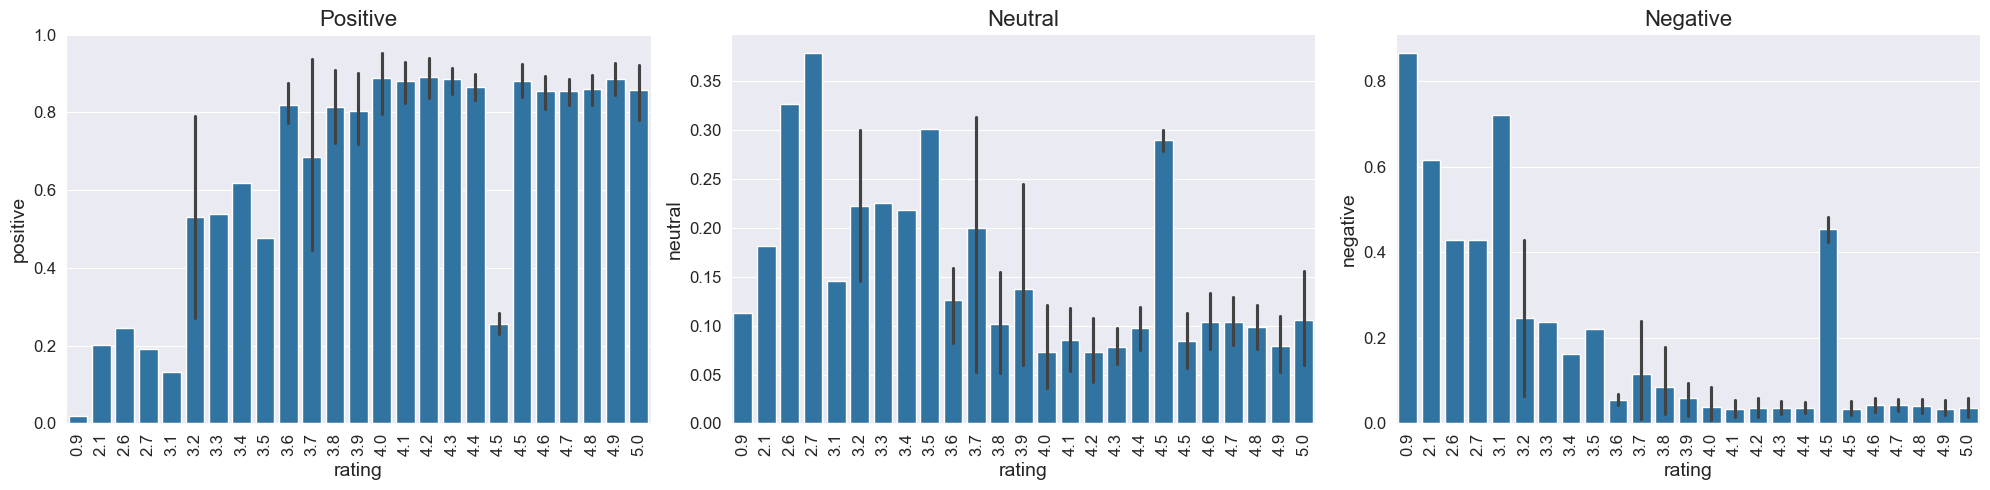

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plotting the barplots
sns.barplot(data=places_df_copy, x='rating', y='positive', ax=axs[0])
sns.barplot(data=places_df_copy, x='rating', y='neutral', ax=axs[1])
sns.barplot(data=places_df_copy, x='rating', y='negative', ax=axs[2])

# Setting titles
axs[0].set_title('Positive', fontsize=16)
axs[1].set_title('Neutral', fontsize=16)
axs[2].set_title('Negative', fontsize=16)

# Adjusting x-ticks, y-ticks, and labels
for ax in axs:
    ax.set_xticklabels([f"{float(label.get_text()):.1f}" for label in ax.get_xticklabels()],
                       rotation=90, fontsize=12)  # Rotate, format, and set font size for x-ticks
    ax.tick_params(axis='y', labelsize=12)  # Set font size for y-ticks
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)  # Increase font size for x-axis labels
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)  # Increase font size for y-axis labels

plt.tight_layout()
plt.show()


In [78]:
places_response_df = places_df_copy[['name', 'lat', 'lng', 'positive']]
places_response_df['name'] = places_response_df['name'].apply(lambda x: x.lower())

In [79]:
places_response_df.head()

,name,lat,lng,positive
0,arugam bay beach,6.840408,81.836848,0.937437
1,mirissa beach,5.944703,80.459161,0.980841
2,weligama beach (surf and stay),5.972486,80.435714,0.954818
3,ahangama,5.973975,80.362159,0.407452
4,hikkaduwa beach,6.137727,80.099060,0.560003


In [80]:
places_response_df.to_csv("../data/places_response.csv", index=False)

# Preprocessing

In [81]:
# Remove Extra Spaces in Strings
users_df['Preferred Activities'] = users_df['Preferred Activities'].apply(lambda x: ' '.join(x.split()))
users_df['Bucket list destinations Sri Lanka'] = users_df['Bucket list destinations Sri Lanka'].apply(lambda x: ' '.join(x.split()))

In [82]:
# Convert String Representations of Lists to Actual Lists
users_df['Preferred Activities'] = users_df['Preferred Activities'].apply(
    lambda x: eval(x) if isinstance(x, str) and x.strip() != '' else ''
)
users_df['Bucket list destinations Sri Lanka'] = users_df['Bucket list destinations Sri Lanka'].apply(
    lambda x: eval(x) if isinstance(x, str) and x.strip() != '' else ''
)

In [83]:
# Convert List Back to Space-Separated Strings
users_df['Preferred Activities'] = users_df['Preferred Activities'].apply(lambda x: " ".join(x))
users_df['Bucket list destinations Sri Lanka'] = users_df['Bucket list destinations Sri Lanka'].apply(
    lambda x: " ".join(x))

In [84]:
# Remove Non-Alphabetic Characters from Text
places_df['latest_reviews'] = places_df['latest_reviews'].apply(
    lambda x: ''.join([i if i.isalpha() or i.isspace() else '' for i in x])
)
places_df['formatted_address'] = places_df['formatted_address'].apply(
    lambda x: ''.join([i if i.isalpha() or i.isspace() else '' for i in x])
)

In [85]:
# Convert Text to Lowercase
places_df['latest_reviews'] = places_df['latest_reviews'].apply(lambda x: x.lower())
places_df['name'] = places_df['name'].apply(lambda x: x.lower())
places_df['formatted_address'] = places_df['formatted_address'].apply(lambda x: x.lower())
users_df['Preferred Activities'] = users_df['Preferred Activities'].apply(lambda x: x.lower())
users_df['Bucket list destinations Sri Lanka'] = users_df['Bucket list destinations Sri Lanka'].apply(lambda x: x.lower())

In [86]:
# Remove Stopwords
stop_words = set(stopwords.words('english'))

places_df['latest_reviews'] = places_df['latest_reviews'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

In [87]:
# Combine Features
combined_features_places = places_df['name'] + ' ' + places_df['formatted_address'] + ' ' + places_df['latest_reviews']

# Destination Based Recommendation

In [112]:
import pickle

In [88]:
tfidf = TfidfVectorizer()
feature_vectors_places = tfidf.fit_transform(combined_features_places)

In [89]:
numerical_features = ['rating', 'user_ratings_total']
numerical_features_df = places_df[numerical_features]

In [90]:
numerical_features_df['rating'] = pd.to_numeric(numerical_features_df['rating'], errors='coerce')
numerical_features_df['user_ratings_total'] = pd.to_numeric(numerical_features_df['user_ratings_total'], errors='coerce')

In [91]:
scaler = MinMaxScaler()
numerical_features_df = scaler.fit_transform(numerical_features_df)

In [92]:
feature_vectors_places = pd.concat([pd.DataFrame(feature_vectors_places.toarray()), pd.DataFrame(numerical_features_df)], axis=1)

In [93]:
feature_vectors_places.head()

,0,1,2,3,4,5,6,7,8,9,...,4584,4585,4586,4587,4588,4589,4590,4591,0,1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.951220,0.058557
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.902439,0.064435
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.853659,0.011157
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.868155,0.059217
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.926829,0.052829


In [94]:
similarity = cosine_similarity(feature_vectors_places)
print(similarity)

[[1.         0.6551984  0.6572064  ... 0.6237815  0.62146214 0.64952985]
 [0.6551984  1.         0.6068069  ... 0.63315411 0.61625847 0.62539269]
 [0.6572064  0.6068069  1.         ... 0.5850745  0.58915595 0.62313537]
 ...
 [0.6237815  0.63315411 0.5850745  ... 1.         0.598422   0.65922242]
 [0.62146214 0.61625847 0.58915595 ... 0.598422   1.         0.63424303]
 [0.64952985 0.62539269 0.62313537 ... 0.65922242 0.63424303 1.        ]]


In [95]:
users_df_original = pd.read_excel("../data/Visitors Preference Dataset.xlsx")

In [96]:
users_df_original["Preferred Activities"] = users_df_original["Preferred Activities"].apply(parse_custom_list)
users_df_original["Bucket list destinations Sri Lanka"] = users_df_original["Bucket list destinations Sri Lanka"].apply(parse_custom_list)

In [97]:
users_df_original.head()

,User ID,Name,Email,Preferred Activities,Bucket list destinations Sri Lanka
0,1,Jennifer Quinn,jennifer.quinn@example.com,"[cycling, historical monuments, village homest...","[Polonnaruwa, Hatton, Anuradhapura, Ella, Hapu..."
1,2,Emily Perry,emily.perry@example.com,"[butterfly watching, hot springs, wildlife vie...","[Madunagala Hot Water Spring, Wilpattu Nationa..."
2,3,Danielle Mcbride,danielle.mcbride@example.com,"[sea cruises, themed parks, craft workshops]","[Mirissa Beach, Negombo Lagoon, Batadombalena ..."
3,4,Angelica Wilson,angelica.wilson@example.com,"[fishing, hot springs, sailing]","[Maha Oya Hot Water Springs, Colombo Port City..."
4,5,Laurie Powers,laurie.powers@example.com,"[history tours, sailing, literary tours]","[Negombo Lagoon, Colombo Port City, Galle Dutc..."


In [98]:
def find_place_index(df, place):    
    place = place.lower()
    
    if place in df['name'].values:
        return df[df['name'] == place].index[0]
    else:
        mask = (
            df['name'].str.lower().str.contains(place) |
            df['formatted_address'].str.lower().str.contains(place) |
            df['latest_reviews'].str.lower().str.contains(place)
        )
        indices = df[mask].index.tolist()
        if indices:
            return indices[0]
        else:
            return "No matches found"

In [99]:
def get_user_bucket_list(user_id):
    user = users_df_original[users_df_original['User ID'] == user_id]
    return user['Bucket list destinations Sri Lanka'].values[0]

In [100]:
def get_best_5_recommendation_based_on_similarity(user_id):
    user_bucket_list = get_user_bucket_list(user_id)
    
    recommendations = {}
    
    for place in user_bucket_list:
        index = find_place_index(places_df, place)
        if index != "No matches found":
            similarity_scores = list(enumerate(similarity[index]))
            similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
            similarity_scores = similarity_scores[0:5]
            top_5_scores  = similarity_scores[0:5]
            top_5_scores = [item for item in top_5_scores if item[1] != 0]
            print("Similar places to", place)
            for i in similarity_scores:
                print(f"{places_df.iloc[i[0]]['name']} - Similarity Score: {i[1]}")
                
            print()
            recommendations[place] = [places_df.iloc[i[0]]['name'] for i in top_5_scores]
            
        else:
            print("No matches found")
            print()
            
    recommended_places_details = {}
    for key, value in recommendations.items():
        places_under_key = []
        for place in value:
            places = places_response_df[places_response_df['name'] == place]
            places_under_key.append(places.values.tolist())
        recommended_places_details[key] = places_under_key
    
    return recommended_places_details

In [101]:
recommended_places_destination = get_best_5_recommendation_based_on_similarity(1)

Similar places to Polonnaruwa
polonnaruwa - Similarity Score: 0.9999999999999998
kandy - Similarity Score: 0.6021329232203232
polonnaruwa ancient city - Similarity Score: 0.5974275510787073
polonnaruwa sivan kovil - Similarity Score: 0.5840673546726256
anuradhapura - Similarity Score: 0.5712171240328225

Similar places to Hatton
sri pada / adam's peak - Similarity Score: 0.9999999999999996
sripada peak wilderness sanctuary - Similarity Score: 0.6502117813219506
ella rock trailhead - Similarity Score: 0.5730569943780734
pidurangala rock - Similarity Score: 0.570712586167212
chariot path - Similarity Score: 0.5661186207550997

Similar places to Anuradhapura
anuradhapura - Similarity Score: 1.0000000000000002
anuradhapura new town - Similarity Score: 0.5924148569025389
polonnaruwa - Similarity Score: 0.5712171240328225
dakkhina stupa - anuradhapura - Similarity Score: 0.5570948846960282
mirisawetiya - Similarity Score: 0.538188042192605

Similar places to Ella
ella rock trailhead - Simila

In [102]:
recommended_places_destination

{'Polonnaruwa': [[['polonnaruwa',
    7.940338400000001,
    81.0187984,
    0.347590172290802]],
  [['kandy', 7.2905715, 80.6337262, 0.38406007591149083]],
  [['polonnaruwa ancient city',
    7.945942499999999,
    81.0003294,
    0.9616823077201844]],
  [['polonnaruwa sivan kovil', 7.9462875, 81.0013281, 0.976676595211029]],
  [['anuradhapura', 8.311351799999999, 80.4036508, 0.48409120440483094]]],
 'Hatton': [[["sri pada / adam's peak",
    6.809642999999999,
    80.4993882,
    0.7490810693966018]],
  [['sripada peak wilderness sanctuary',
    6.817866,
    80.4892398,
    0.5928887599706649]],
  [['ella rock trailhead', 6.8578491, 81.04402259999999, 0.8022804766893387]],
  [['pidurangala rock', 7.966388599999999, 80.7618379, 0.8928797642389933]],
  [['chariot path', 7.0844375, 80.7239375, 0.9629180788993835]]],
 'Anuradhapura': [[['anuradhapura',
    8.311351799999999,
    80.4036508,
    0.48409120440483094]],
  [['anuradhapura new town', 8.3227654, 80.4025767, 0.6956054642796516

# Activity Based Recommendation

In [103]:
users_df_original.head()

,User ID,Name,Email,Preferred Activities,Bucket list destinations Sri Lanka
0,1,Jennifer Quinn,jennifer.quinn@example.com,"[cycling, historical monuments, village homest...","[Polonnaruwa, Hatton, Anuradhapura, Ella, Hapu..."
1,2,Emily Perry,emily.perry@example.com,"[butterfly watching, hot springs, wildlife vie...","[Madunagala Hot Water Spring, Wilpattu Nationa..."
2,3,Danielle Mcbride,danielle.mcbride@example.com,"[sea cruises, themed parks, craft workshops]","[Mirissa Beach, Negombo Lagoon, Batadombalena ..."
3,4,Angelica Wilson,angelica.wilson@example.com,"[fishing, hot springs, sailing]","[Maha Oya Hot Water Springs, Colombo Port City..."
4,5,Laurie Powers,laurie.powers@example.com,"[history tours, sailing, literary tours]","[Negombo Lagoon, Colombo Port City, Galle Dutc..."


In [104]:
places_df.head()

,name,lat,lng,formatted_address,rating,user_ratings_total,latest_reviews
0,arugam bay beach,6.840408,81.836848,arugam bay beach sri lanka,4.800000,1591.000000,arugam bay beach surfers paradise spent incred...
1,mirissa beach,5.944703,80.459161,mirissa sri lanka,4.600000,1748.000000,mirissa beach truly gem sri lankaãââs southern...
2,weligama beach (surf and stay),5.972486,80.435714,weligama sri lanka,4.400000,325.000000,weligama beach fantastic spot beginner experie...
3,ahangama,5.973975,80.362159,ahangama sri lanka,4.459437,1608.639437,ahangama bit disappointing solo traveler surfi...
4,hikkaduwa beach,6.137727,80.099060,hikkaduwa beach sri lanka,4.700000,1438.000000,hikkaduwa beach delightful escape solo travele...


In [105]:
tfidf2 = TfidfVectorizer()
feature_vectors_activities = tfidf2.fit_transform(places_df['latest_reviews'])
print(feature_vectors_activities)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 49648 stored elements and shape (411, 4414)>
  Coords	Values
  (0, 200)	0.4192624239330504
  (0, 292)	0.37333697291090895
  (0, 295)	0.4877505070569952
  (0, 3724)	0.06929446124685
  (0, 2658)	0.05401997759818623
  (0, 3549)	0.04934693519040975
  (0, 1817)	0.039935264518066615
  (0, 881)	0.11259442834665034
  (0, 3173)	0.06929446124685
  (0, 4262)	0.09261753976495382
  (0, 2153)	0.058974384089136814
  (0, 3721)	0.20175530038828052
  (0, 3302)	0.07847955145127831
  (0, 1328)	0.05241143197990454
  (0, 314)	0.06548230437775347
  (0, 2120)	0.05790125902429009
  (0, 215)	0.040494914584475974
  (0, 2032)	0.0612623835178034
  (0, 1444)	0.032974811449928976
  (0, 2154)	0.09037655182394773
  (0, 1352)	0.06548230437775347
  (0, 3960)	0.05715243245154152
  (0, 2160)	0.04042610893208543
  (0, 877)	0.021993569424204672
  (0, 3725)	0.17145729735462456
  :	:
  (410, 1281)	0.05218975339173715
  (410, 1376)	0.09203584330732836
  (410, 1654)	

In [115]:
with open("../models/feature_vectors_activities.pkl", "wb") as file:
    pickle.dump(feature_vectors_activities, file)
    
with open("../models/tfidf2.pkl", "wb") as file:
    pickle.dump(tfidf2, file)

In [106]:
def recommended_place_by_each_activity(user_id):
    user = users_df_original[users_df_original['User ID'] == user_id]
    activities = user['Preferred Activities'].values[0]
    
    recommendations = {}
    
    for activity in activities:
        activity_vector = tfidf2.transform([activity])
        similarity = cosine_similarity(feature_vectors_activities, activity_vector)
        similarity_scores = list(enumerate(similarity))
        similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
        top_5_scores  = similarity_scores[0:5]
        top_5_scores = [item for item in top_5_scores if item[1] != 0]
        print("Places for", activity)
        for i in top_5_scores:
            print(f"{places_df.iloc[i[0]]['name']} - Similarity Score: {i[1]}")
        
        print()
        recommendations[activity] = [places_df.iloc[i[0]]['name'] for i in top_5_scores]
        
    recommended_places_details = {}
    for key, value in recommendations.items():
        places_under_key = []
        for place in value:
            places = places_response_df[places_response_df['name'] == place]
            places_under_key.append(places.values.tolist())
        recommended_places_details[key] = places_under_key
    
    return recommended_places_details

In [107]:
recommended_places_activity = recommended_place_by_each_activity(1)

Places for cycling
viharamahadevi park - Similarity Score: [0.20789757]

Places for historical monuments
polonnaruwa - Similarity Score: [0.23543749]
anuradhapura - Similarity Score: [0.21674337]
batticaloa dutch fort - Similarity Score: [0.06737463]
thuparamaya - Similarity Score: [0.0590479]
fort frederick - Similarity Score: [0.05166107]

Places for village homestays
mandathivu beach - Similarity Score: [0.10671404]
ãƒâ ã‚â¶ã‚â”ãƒâ ã‚â¶ã‚âšãƒâ ã‚â¶ã‚â±ãƒâ ã‚â·ã‚âšãƒâ ã‚â¶ã‚â¯ ãƒâ ã‚â·ã‚â€ãƒâ ã‚â·ã‚â™ãƒâ ã‚â¶ã‚â»ãƒâ ã‚â·ã‚â… | ãƒâ ã‚â®ã‚â‰ãƒâ ã‚â®ã‚â•ãƒâ ã‚â®ã‚â¨ãƒâ ã‚â¯ã‚â_x008d_ãƒâ ã‚â®ã‚â¤ãƒâ ã‚â¯ã‚âˆ ãƒâ ã‚â®ã‚â•ãƒâ ã‚â®ã‚âÿãƒâ ã‚â®ã‚â±ãƒâ ã‚â¯ã‚â_x008d_ãƒâ ã‚â®ã‚â•ãƒâ ã‚â®ã‚â°ãƒâ ã‚â¯ã‚âˆ | okanda beach - Similarity Score: [0.09862983]
colombo national museum - Similarity Score: [0.0798996]


In [108]:
recommended_places_activity

{'cycling': [[['viharamahadevi park',
    6.913390699999999,
    79.86174009999999,
    0.9833759069442749]]],
 'historical monuments': [[['polonnaruwa',
    7.940338400000001,
    81.0187984,
    0.347590172290802]],
  [['anuradhapura', 8.311351799999999, 80.4036508, 0.48409120440483094]],
  [['batticaloa dutch fort', 7.7118126, 81.702124, 0.9448631763458252]],
  [['thuparamaya', 8.3553447, 80.3964751, 0.6273491852916777]],
  [['fort frederick', 8.5772776, 81.2432785, 0.9438196420669556]]],
 'village homestays': [[['mandathivu beach',
    9.6035805,
    80.0002593,
    0.6956280202139169]],
  [['ãƒâ\xa0ã‚â¶ã‚â”ãƒâ\xa0ã‚â¶ã‚âšãƒâ\xa0ã‚â¶ã‚â±ãƒâ\xa0ã‚â·ã‚âšãƒâ\xa0ã‚â¶ã‚â¯ ãƒâ\xa0ã‚â·ã‚â€ãƒâ\xa0ã‚â·ã‚â™ãƒâ\xa0ã‚â¶ã‚â»ãƒâ\xa0ã‚â·ã‚â… | ãƒâ\xa0ã‚â®ã‚â‰ãƒâ\xa0ã‚â®ã‚â•ãƒâ\xa0ã‚â®ã‚â¨ãƒâ\xa0ã‚â¯ã‚â_x008d_ãƒâ\xa0ã‚â®ã‚â¤ãƒâ\xa0ã‚â¯ã‚âˆ ãƒâ\xa0ã‚â®ã‚â•ãƒâ\xa0ã‚â®ã‚âÿãƒâ\xa0ã‚â®ã‚â±ãƒâ\xa0ã‚â¯ã‚â_x008d_ãƒâ\xa0ã‚â®ã‚â•ãƒâ\xa0ã‚â®ã‚â°ãƒâ\xa0ã‚â¯ã‚âˆ | okanda beach',
    6.6279397,
    81.7708182,


# Hybrid Recommendation

In [109]:
def get_hybrid_recommendation(user_id):
    destination_based_recommendation = get_best_5_recommendation_based_on_similarity(user_id)
    activity_based_recommendation = recommended_place_by_each_activity(user_id)
    
    hybrid_recommendation = {
        "destination_based_recommendation": destination_based_recommendation,
        "activity_based_recommendation": activity_based_recommendation
    }
    
    return hybrid_recommendation

In [110]:
hybrid_recommendation = get_hybrid_recommendation(5)

Similar places to Negombo Lagoon
negombo lagoon - Similarity Score: 1.0
kalpitiya lagoon - Similarity Score: 0.6629690020821009
umari lagoon - Similarity Score: 0.6399880139494654
thandiyadi lagoon - Similarity Score: 0.6330051735489794
negombo - Similarity Score: 0.6288240710222952

No matches found

Similar places to Galle Dutch Fort
galle dutch fort - Similarity Score: 0.9999999999999996
galle fort attractions and jumpers sri lanka - Similarity Score: 0.7284236561381952
dutch fort - jaffna - Similarity Score: 0.6796269454229478
sri dalada maligawa - Similarity Score: 0.6205718790535567
diyatha uyana - Similarity Score: 0.6144281206591631

Similar places to Sigiriya
sigiriya - Similarity Score: 1.0
pidurangala rock - Similarity Score: 0.6794239894944187
sri dalada maligawa - Similarity Score: 0.6465513673112363
diyatha uyana - Similarity Score: 0.6225651855961284
royal botanic gardens, peradeniya - Similarity Score: 0.6189888594995057

Similar places to Jaffna Public Library
jaffna p

In [111]:
hybrid_recommendation

{'destination_based_recommendation': {'Negombo Lagoon': [[['negombo lagoon',
     7.1580045,
     79.84648039999999,
     0.745280203051292]],
   [['kalpitiya lagoon', 8.2412725, 79.7441936, 0.9674260258674622]],
   [['umari lagoon', 7.0448379, 81.8595828, 0.9856510996818543]],
   [['thandiyadi lagoon', 7.0519269, 81.8457198, 0.10813038945198059]],
   [['negombo', 7.205520799999999, 79.8512562, 0.22012045118026435]]],
  'Galle Dutch Fort': [[['galle dutch fort',
     6.030459199999999,
     80.2150207,
     0.6796961255930364]],
   [['galle fort attractions and jumpers sri lanka',
     6.0304644,
     80.2150237,
     0.8013804838992655]],
   [['dutch fort - jaffna', 9.6620307, 80.0084252, 0.8311972107206073]],
   [['sri dalada maligawa', 7.293609, 80.641325, 0.6292869554211696]],
   [['diyatha uyana', 6.904575, 79.9098313, 0.8966570794582367]]],
  'Sigiriya': [[['sigiriya',
     7.957032699999999,
     80.760257,
     0.6326680007306013]],
   [['pidurangala rock', 7.966388599999999, 8